# Virgo: POC modeling

## Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import plotly.express as px
import plotly.offline as pyo

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

In [4]:
import data_functions
import configs

In [5]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
tf.__version__

'2.11.0'

## Transfomations

In [7]:
n_days = configs.data_configs.n_days
lag_days = configs.data_configs.lags
window = configs.data_configs.window
ref_price = configs.data_configs.ref_price
std_column = configs.data_configs.std_column
logdif_column = configs.data_configs.logdif_column

In [8]:
print(f'the return is given for {lag_days} days')

the return is given for 3 days


In [9]:
appl_stock = data_functions.get_stock_data(stock_code = "AAPL", n_days = n_days, window = window, lags = lag_days)
appl_stock = data_functions.shape_data(appl_stock, 'apple', ref_price, std_column, logdif_column)

In [10]:
test_data = '2022-12-01'### higher equal

In [11]:
appl_stock.head()

,Date,apple_price,apple_stv,apple_logdif
10372,2022-02-01 00:00:00-05:00,173.602463,7.181806,0.092268
10373,2022-02-02 00:00:00-05:00,174.825363,7.805716,0.031837
10374,2022-02-03 00:00:00-05:00,171.902313,7.126186,-0.010815
10375,2022-02-04 00:00:00-05:00,171.613632,5.662439,-0.011522
10376,2022-02-07 00:00:00-05:00,170.886917,1.896539,-0.022786


#### dividir datos

In [12]:
appl_stock = appl_stock.set_index('Date')

In [13]:
column_indices = {name: i for i, name in enumerate(appl_stock.columns)}

n = len(appl_stock)
train_df = appl_stock[0:int(n*0.7)]
val_df = appl_stock[int(n*0.7):int(n*0.9)]
test_df = appl_stock[int(n*0.9):]

num_features = appl_stock.shape[1]

<b> normalization

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [15]:
train_df.head()

,apple_price,apple_stv,apple_logdif
Date,,,
2022-02-01 00:00:00-05:00,1.389424,2.798726,2.662337
2022-02-02 00:00:00-05:00,1.491715,3.268523,0.969062
2022-02-03 00:00:00-05:00,1.247214,2.756845,-0.226019
2022-02-04 00:00:00-05:00,1.223067,1.654664,-0.245851
2022-02-07 00:00:00-05:00,1.162280,-1.181008,-0.561442


In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)  ### for each label column one dict with index
            }
            
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns) ### for each column observation one dict with index
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width  # number of time steps to predict
        self.shift = shift  ## or offset

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  ## indexes of the input data

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] ## indexes of the label data

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['apple_logdif'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['apple_logdif']

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['apple_logdif'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['apple_logdif']

In [19]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]  ## select the train slice
    labels = features[:, self.labels_slice, :]  ## select the label slice
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)  ## selecting the column 

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [20]:
## adding the function to the class Window generator
WindowGenerator.split_window = split_window

In [21]:
np.array(train_df[:w2.total_window_size])

array([[ 1.38942412,  2.79872639,  2.66233652],
       [ 1.49171457,  3.26852279,  0.96906241],
       [ 1.24721378,  2.75684535, -0.22601904],
       [ 1.22306683,  1.65466383, -0.24585087],
       [ 1.16228018, -1.1810076 , -0.56144182],
       [ 1.42624378, -1.50279239,  0.42371984],
       [ 1.54698236, -1.29437372,  0.702242  ]])

In [22]:
# Stack three slices, the length of the total window some selections
example_window = tf.stack(
    [np.array(train_df[:w2.total_window_size]),
    np.array(train_df[20:20+w2.total_window_size]),
    np.array(train_df[50:50+w2.total_window_size]),
    np.array(train_df[90:90+w2.total_window_size]),
    np.array(train_df[120:120+w2.total_window_size]),
    np.array(train_df[150:150+w2.total_window_size]),
    ]
)

In [23]:
example_window.shape ###  4 slices, 7 observations and 3 features per slice

TensorShape([6, 7, 3])

In [24]:
example_inputs, example_labels = w2.split_window(example_window)

In [25]:
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (6, 7, 3)
Inputs shape: (6, 6, 3)
Labels shape: (6, 1, 1)


<b> ver cortes

In [26]:
w2.example = example_inputs, example_labels

In [27]:
w2.column_indices

{'apple_price': 0, 'apple_stv': 1, 'apple_logdif': 2}

In [28]:
def plot(self, model=None, plot_col='apple_logdif', max_subplots=4):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

In [29]:
WindowGenerator.plot = plot

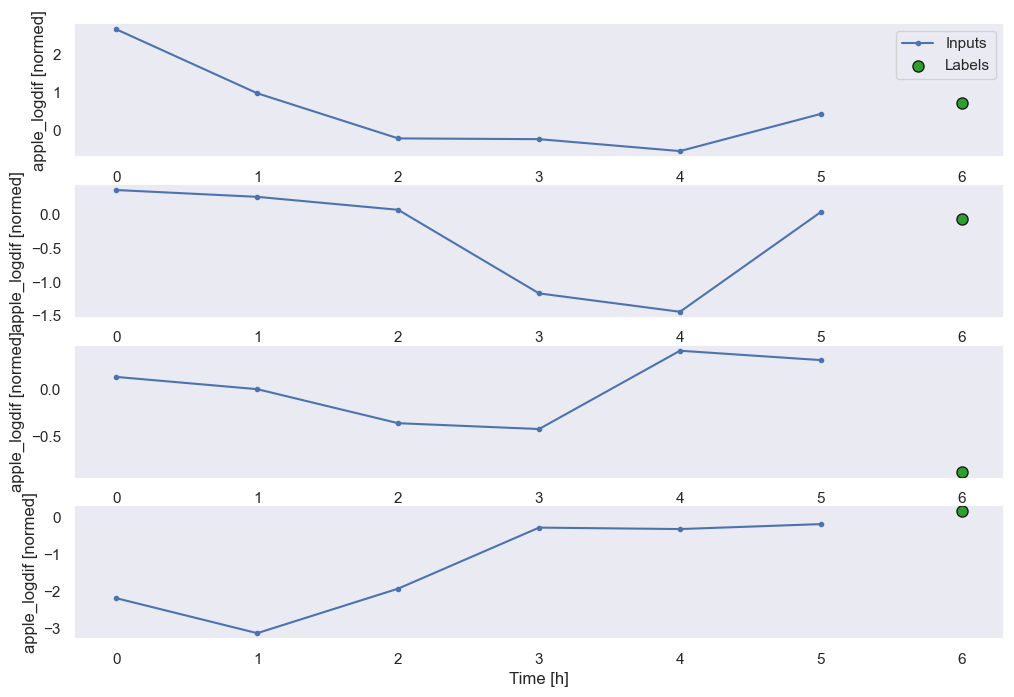

In [30]:
w2.plot(plot_col='apple_logdif')

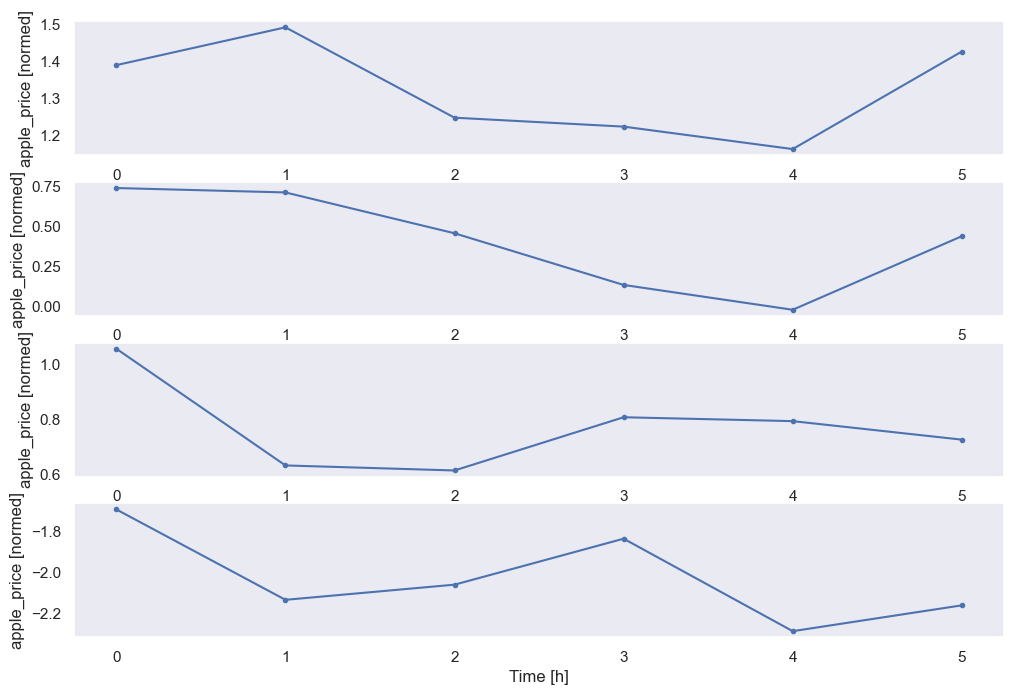

In [31]:
w2.plot(plot_col='apple_price')

In [33]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

In [34]:
WindowGenerator.make_dataset = make_dataset

In [35]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [36]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [40]:
for i,_ in enumerate(w2.train):
    print(i)

0
1
2
3
4
5


In [ ]:
for a,b in w2.train.take(0):
    a= a.numpy()
    b= b.numpy()

In [ ]:
a.shape

(32, 6, 3)

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['apple_logdif'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['apple_logdif']

In [43]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['apple_logdif'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['apple_logdif']

In [44]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
              return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [45]:
baseline = Baseline(label_index=column_indices['apple_logdif'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2/2 [==============================] - 0s 10ms/step - loss: 1.2006 - mean_absolute_error: 0.8824


In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


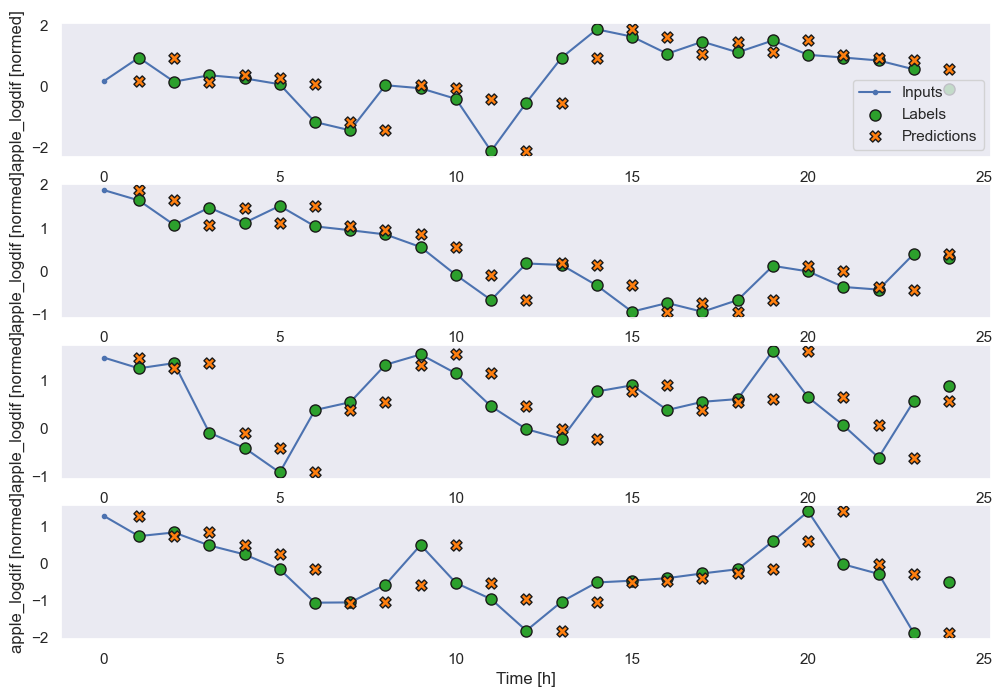

In [47]:
wide_window.plot(baseline)

In [48]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['apple_logdif'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['apple_logdif']

In [49]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 3)
Output shape: (32, 24, 1)


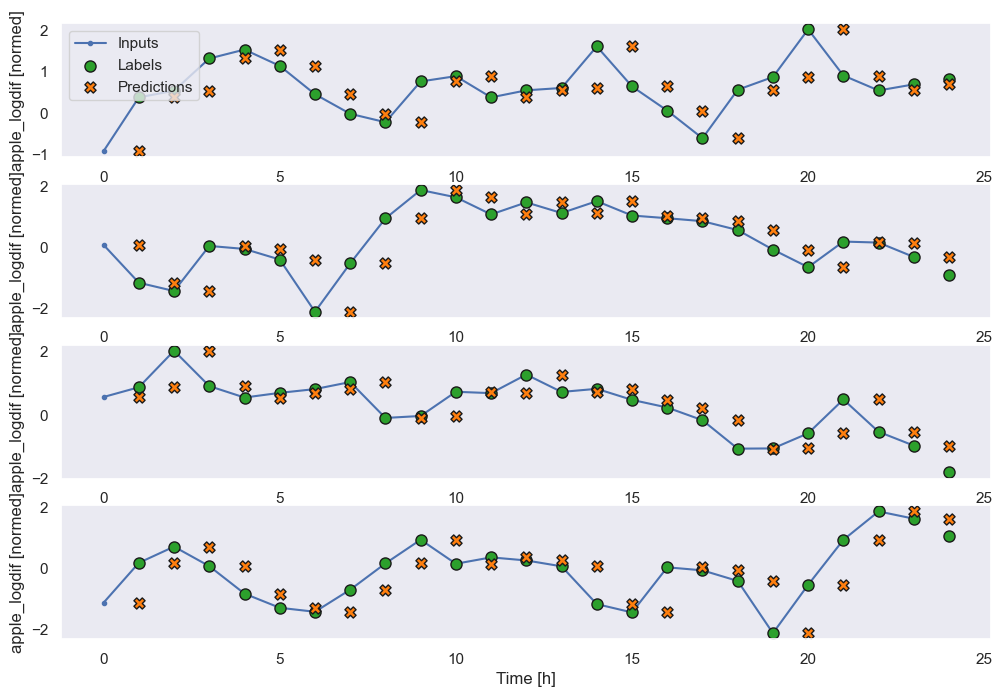

In [50]:
wide_window.plot(baseline)

In [51]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [52]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
6/6 [==============================] - 2s 74ms/step - loss: 0.8966 - mean_absolute_error: 0.7486 - val_loss: 1.0278 - val_mean_absolute_error: 0.8217
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 0.7090 - mean_absolute_error: 0.6654 - val_loss: 0.9617 - val_mean_absolute_error: 0.7983
Epoch 3/20
6/6 [==============================] - 0s 18ms/step - loss: 0.6200 - mean_absolute_error: 0.6181 - val_loss: 0.9528 - val_mean_absolute_error: 0.8074
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 0.5922 - mean_absolute_error: 0.5966 - val_loss: 0.9741 - val_mean_absolute_error: 0.8229
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.9741 - mean_absolute_error: 0.8239


In [82]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['apple_logdif'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['apple_logdif']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

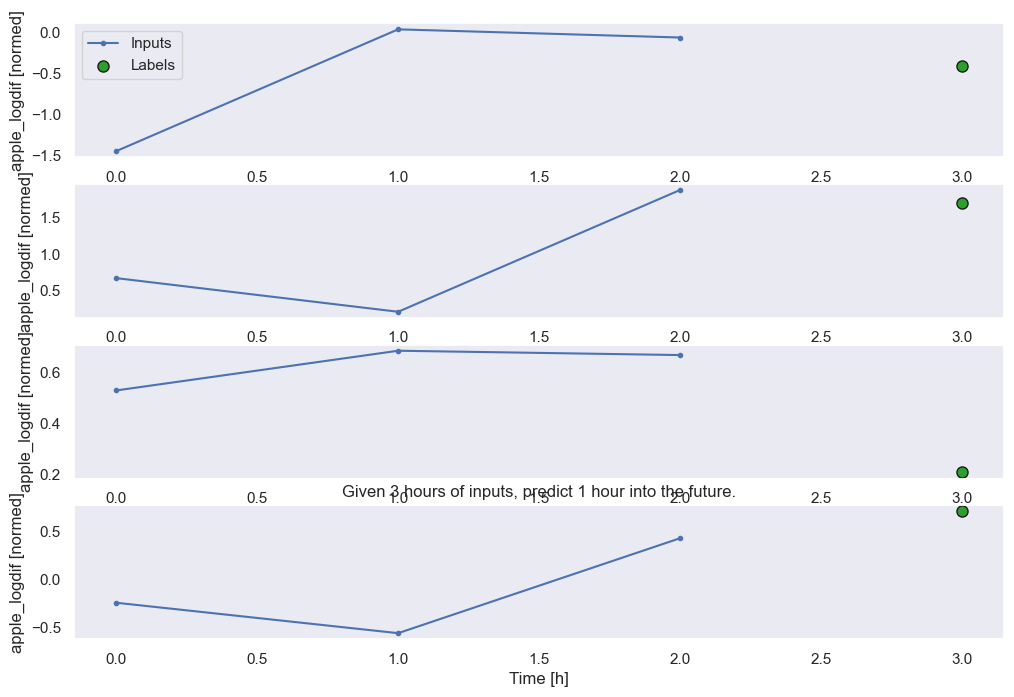

In [83]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [84]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [85]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 8ms/step - loss: 0.8049 - mean_absolute_error: 0.7540


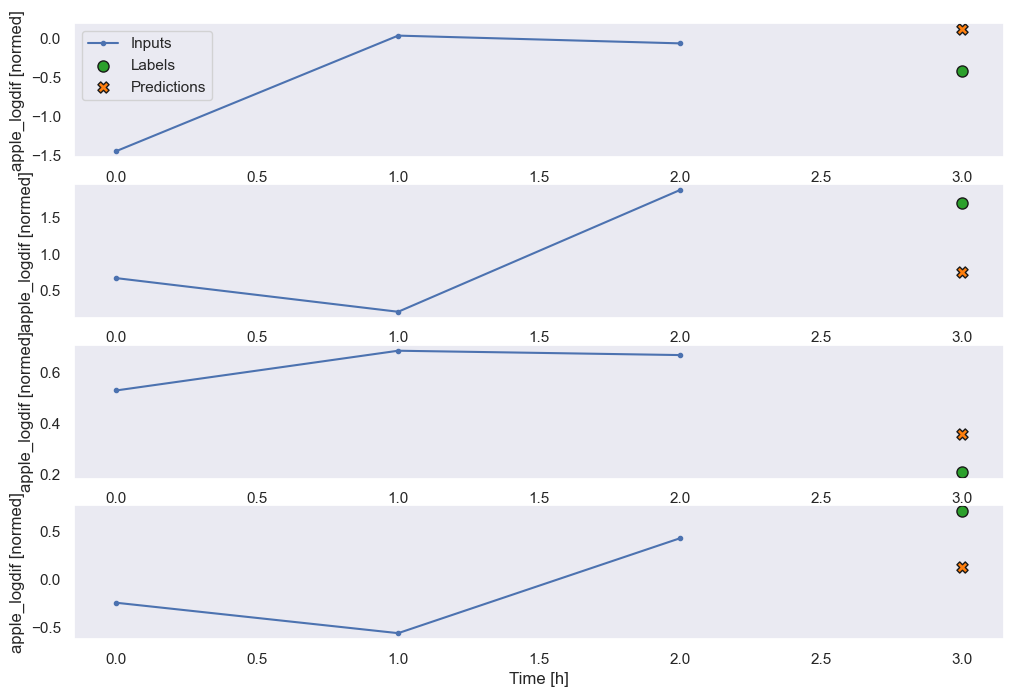

In [86]:
conv_window.plot(multi_step_dense)

In [ ]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

In [88]:
for i,_ in enumerate(conv_window.train):
    print(i)

0
1
2
3
4
5


In [90]:
for i,_ in enumerate(conv_window.val):
    print(i)

0
1


In [58]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [59]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

2/2 [==============================] - 0s 6ms/step - loss: 0.8805 - mean_absolute_error: 0.7662


In [60]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['apple_logdif'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['apple_logdif']

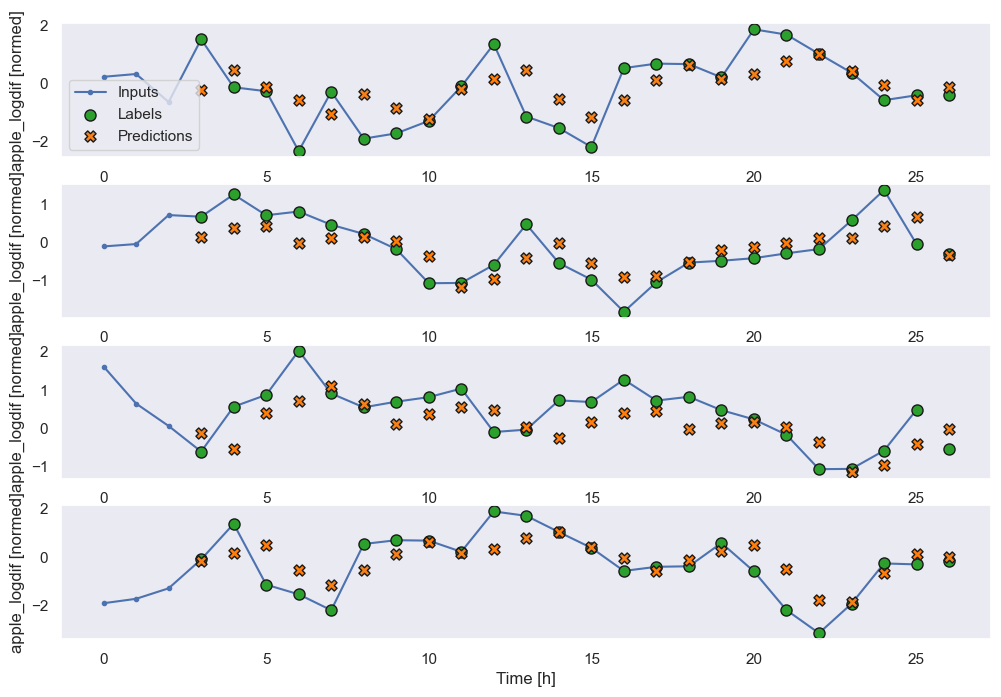

In [61]:
wide_conv_window.plot(conv_model)

In [62]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [63]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 112ms/step - loss: 1.1467 - mean_absolute_error: 0.8695


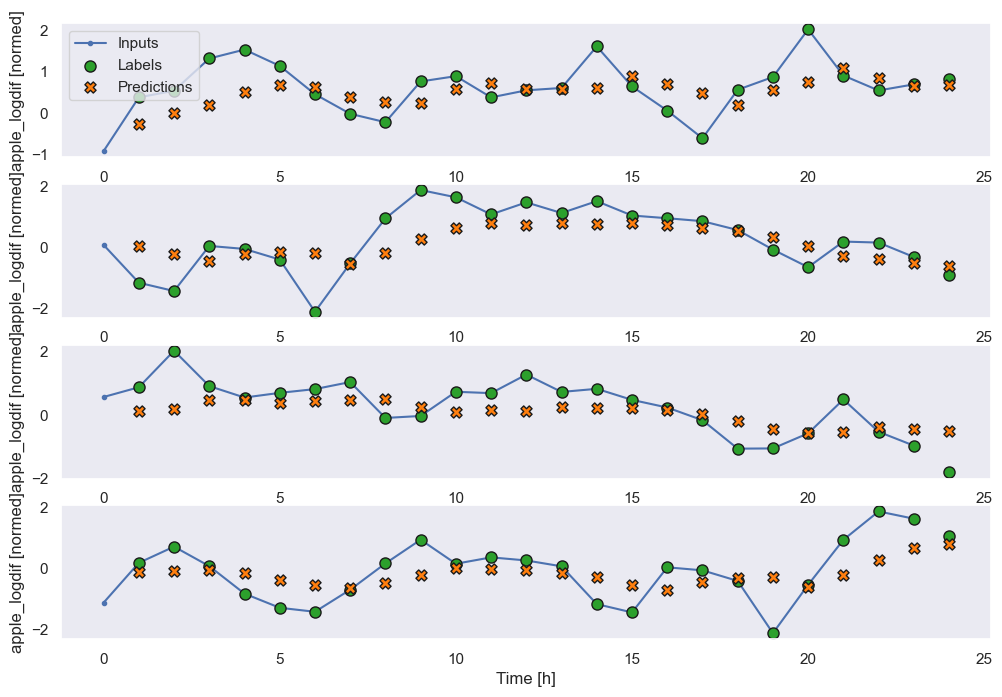

In [64]:
wide_window.plot(lstm_model)

## multiple steps in the future prediction

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

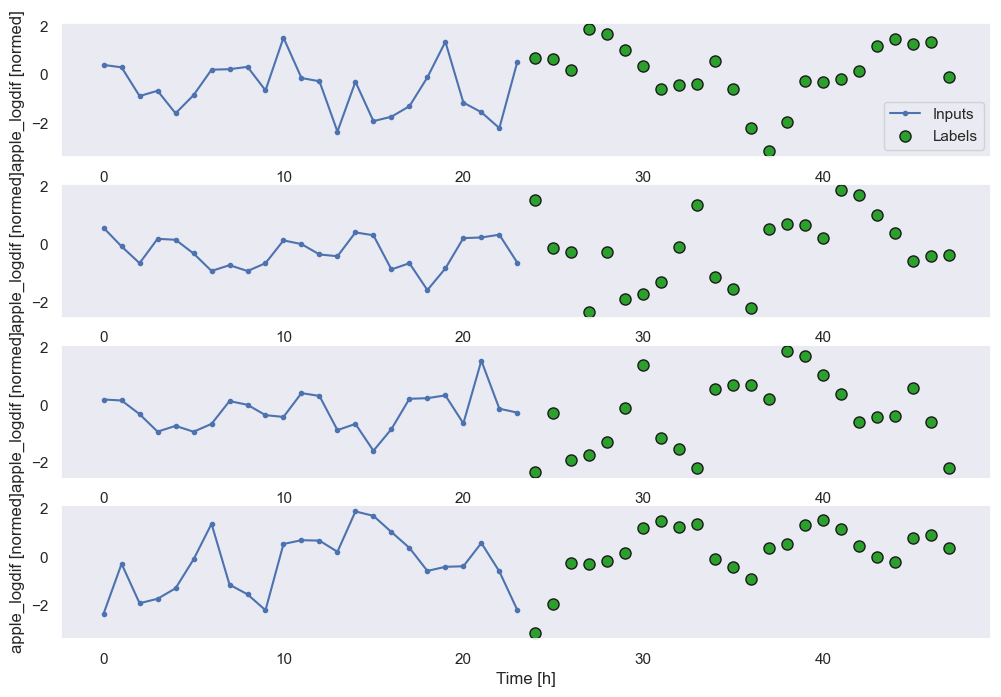

In [65]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [66]:
train_df.shape

(168, 3)

In [67]:
multi_val_performance = {}
multi_performance = {}

In [74]:
for i,a in enumerate(multi_window.train):
    i = i+1
print(i)

4


In [79]:
a[0].shape

TensorShape([25, 24, 3])

In [81]:
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [69]:
multi_window.input_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [70]:
multi_window.label_indices

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47])

1/1 [==============================] - 0s 121ms/step - loss: 1.1138 - mean_absolute_error: 0.8273


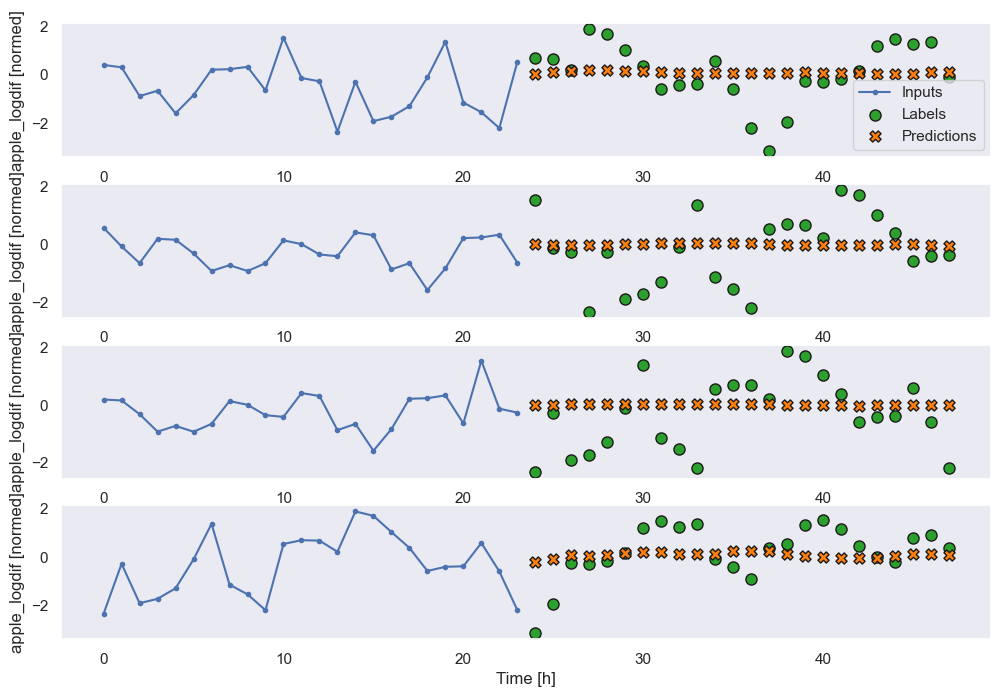

In [71]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

1/1 [==============================] - 0s 101ms/step - loss: 0.8521 - mean_absolute_error: 0.7671


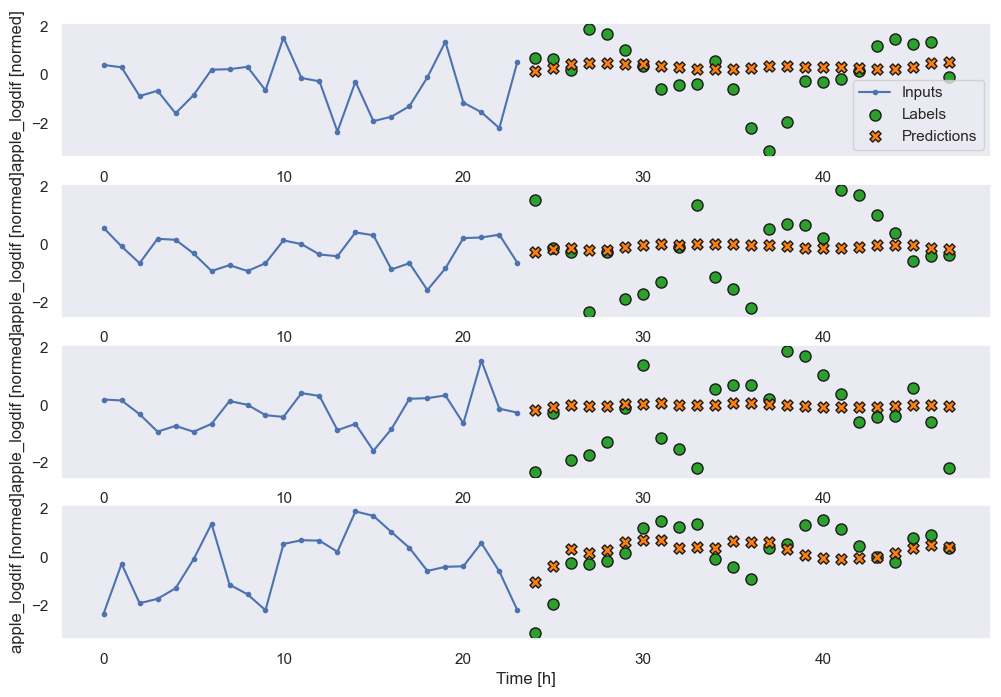

In [72]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)